https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tpu-tensorflow-training

<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Cassava%20Leaf%20Disease%20Classification/banner.png" width="1000"></center>
<br>
<center><h1>Cassava Leaf Disease - TPU Tensorflow - Training</h1></center>
<br>

#### This an introdutory notebook with a quick EDA using the `tfrecords` and a simple demonstration on how to use deep learning with TPU for image classification.

- [Inference notebook](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tpu-tensorflow-inference/data)
- Dataset source `resized` [128x128](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-128x128), [256x256](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-256x256), [384x384](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-384x384), [512x512](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-512x512)
- Dataset source `center cropped` [128x128](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-center-128x128), [256x256](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-center-256x256), [384x384](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-center-384x384), [512x512](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-center-512x512)
- Dataset source [discussion thread](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198744)
- Dataset [creation source](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-stratified-tfrecords-256x256)

> This was based on the [competition baseline](https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease) and on one of my previous works [Flower Classification with TPUs - EDA and Baseline](https://www.kaggle.com/dimitreoliveira/flower-classification-with-tpus-eda-and-baseline), from the [Petals to the Metal: Flower Classification on TPU](https://www.kaggle.com/c/tpu-getting-started) competition.

## Dependencies

In [ ]:
!pip install --quiet efficientnet

     |████████████████████████████████| 51kB 2.2MB/s 


In [ ]:
import math, os, re, warnings, random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# from kaggle_datasets import KaggleDatasets
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import efficientnet.tfkeras as efn

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

In [ ]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.100.106.66:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.100.106.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.106.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


# Model parameters

In [ ]:
BATCH_SIZE = 16 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS
EPOCHS = 30
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 5
ES_PATIENCE = 10
N_FOLDS = 5

# Load data

Here we have three options of data sources
- Original TFRecods data
- Original JPG images converted to TFRecods and resized
- Original JPG images converted to TFRecods square center cropped and resized

We are using the last option

[get gs_path_dic](https://www.kaggle.com/masterstar/get-gcs-cassava-leaf-disease-classification)

In [ ]:

gs_path_dic = {
    
    "base": 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028',
    128: {
        'center': 'gs://kds-69d3f6b71f52700b069d87735ddb922c0a4d15d4e29b5a1dd33b57fd',
        'all': 'gs://kds-ee42b8bb873eae5116ddcec531243c4b8c45627d90eff0a381ab07e6'
        },
    256: {
     'center': 'gs://kds-d73483e23749c1048714a48ce82c969a5bcc6b22265bc7932d3b6f6c',
     'all': 'gs://kds-744108dd3b798a129ac432a6546fc800c5a262dcc5e001966b10d705'
     },
    384: {
     'center': 'gs://kds-938015b93dcb3fd62e54cc7d4e8467a8e9805ed9be0a8c63a07ecadd',
     'all': 'gs://kds-7dc640faafd5617e1d6f0389a042c5257d241853bbfbb1b137e2aaac'
     },
 512: {
     'center': 'gs://kds-8bc07429282178be9cf47cdd9febcef9fe1e41076388a327dc783c44',
     'all': 'gs://kds-cd3afa5e702b2d7399a2875a0a47e9510f262df3e39fdd3b3b133111'
     }
 }

In [ ]:
!pip install fsspec

     |████████████████████████████████| 102kB 3.5MB/s 


In [ ]:
!pip install gcsfs

     |████████████████████████████████| 1.3MB 6.9MB/s 
     |████████████████████████████████| 296kB 20.5MB/s 
     |████████████████████████████████| 143kB 29.2MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=e51e57d3b54f780a06fe08cef8eaf4f3a15acb854906b08d05306dae4337be84
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


database_base_path = gs_path_dic["base"]
train = pd.read_csv(f'{database_base_path}/train.csv')
print(f'Train samples: {len(train)}')

# GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification') # Original dataset
# GCS_PATH = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-{HEIGHT}x{WIDTH}') # Only resized
# GCS_PATH = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-center-{HEIGHT}x{WIDTH}') # Center croped and resized
GCS_PATH = gs_path_dic[HEIGHT]["center"]

# TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/*.tfrec') # Original TFRecords
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

Train samples: 21397
GCS: train images: 21395


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Augmentation

In [ ]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    return image, label

## Auxiliary functions

In [ ]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [ ]:
# Datasets utility functions
def decode_image(image_data):
    """
        1. Decode a JPEG-encoded image to a uint8 tensor.
        2. Cast tensor to float and normalizes (range between 0 and 1).
        3. Resize and reshape images to the expected size.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
                      
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
    else:
        label_or_name =  example['image_name']
    return image, label_or_name

def load_dataset(filenames, labeled=True, ordered=False):
    """
        Create a Tensorflow dataset from TFRecords.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    dataset = load_dataset(FILENAMES, labeled=labeled, ordered=ordered)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', 
                  fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Model evaluation
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# EDA

## First let's look at some samples from each set

### Class map
```
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy
```

### Training samples

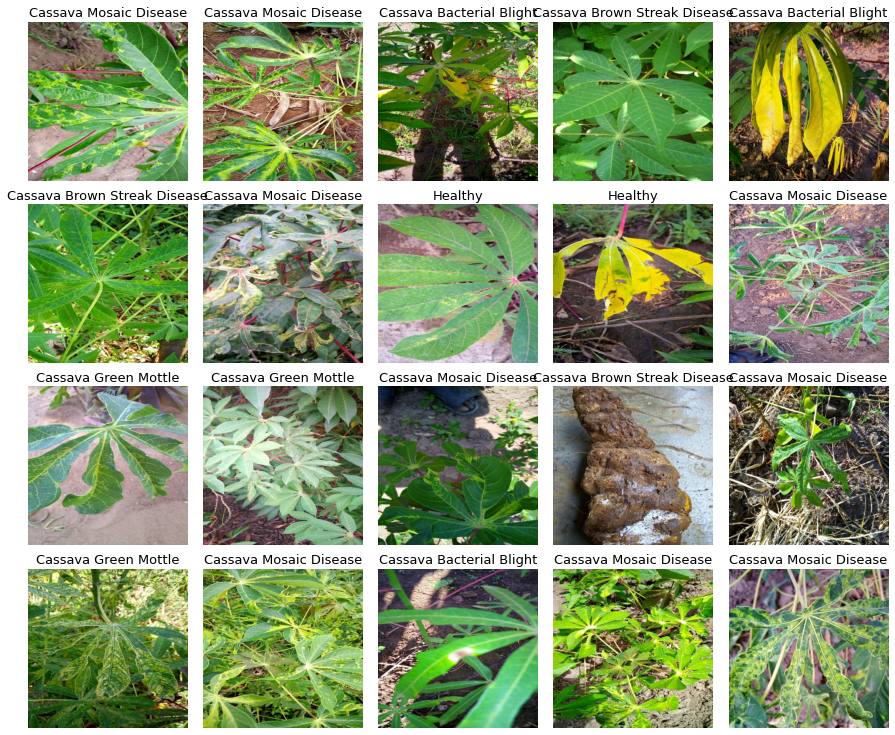

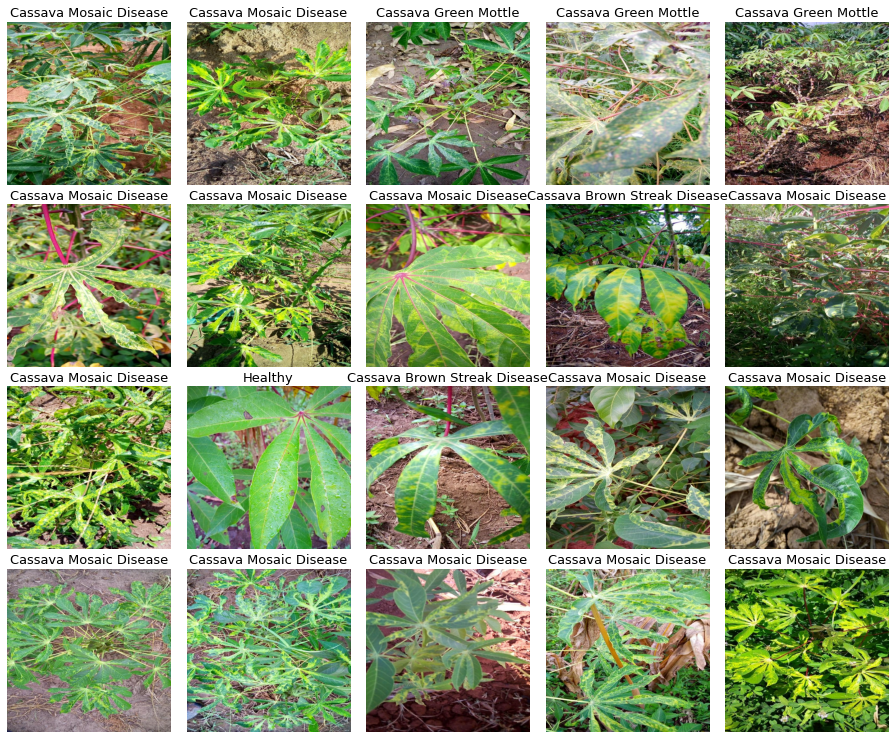

In [ ]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

The important thing here is that the image quality seems to be very consistent over the dataset, this will make things easier for the model to generalize.

On the other side, some of the images have a lot of leaves, some are far from the plant, and a few don't have leaves at all.

## Label distribution

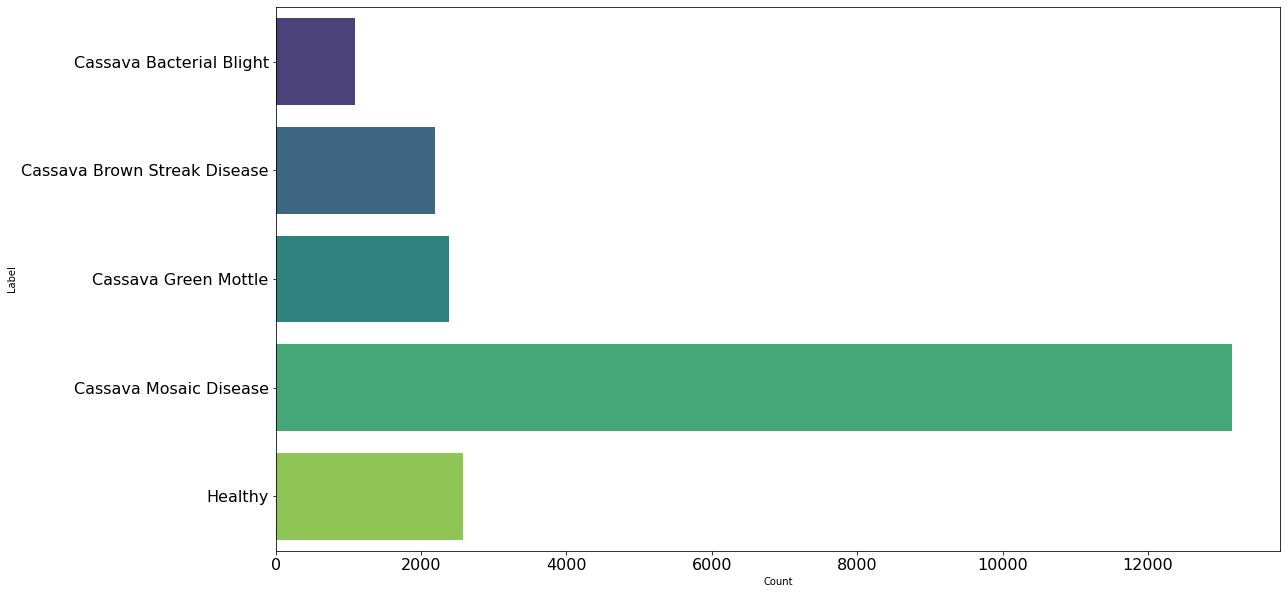

In [ ]:
label_count = train.groupby('label', as_index=False).count()
label_count.rename(columns={'image_id': 'Count', 'label': 'Label'}, inplace=True)
label_count['Label'] = label_count['Label'].apply(lambda x: CLASSES[x])

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax = sns.barplot(x=label_count['Count'], y=label_count['Label'], palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

As we can see the dataset is very unbalanced, most of the samples belong to the `Cassava Mosaic Disease`, but all the other classes sizes are much closer.

### Learning rate schedule

We are going to use a `cosine learning rate schedule with a warm-up phase`, this may be a good idea since we are using a pre-trained model, the warm-up phase will be useful to avoid the pre-trained weights degradation resulting in catastrophic forgetting, during the schedule the learning rate will slowly decrease to very low values, this helps the model to land on more stable weights.

30 total epochs and 167 steps per epoch
Learning rate schedule: 1e-08 to 0.00024 to 8.11e-07


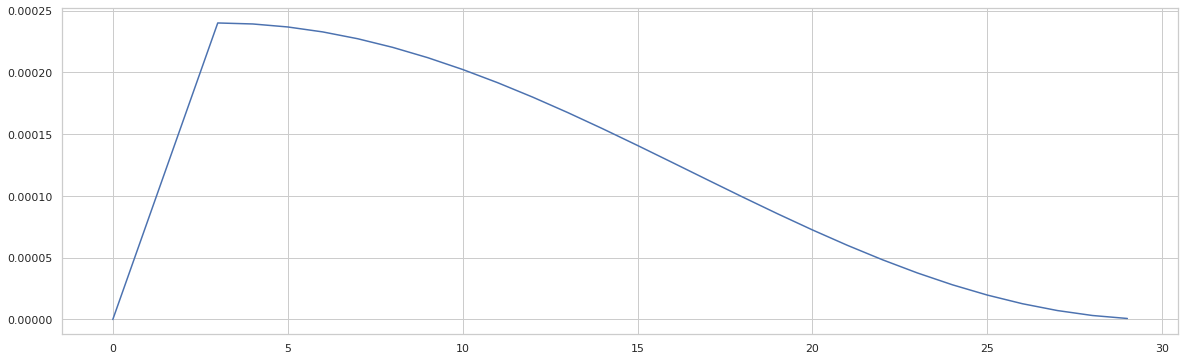

In [ ]:
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5


def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Model

Here I am using EfficientNet, compared to many of the popular computer vision models it has a very good trade-off, between `number of parameters` and `accuracy` on `ImageNet`, I am using the implementation from this [GitHub](https://github.com/qubvel/efficientnet) repository.

![](https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Flower%20Classification%20with%20TPUs/EfficientNet_comparison.jpg)

In [ ]:
def model_fn(input_shape, N_CLASSES):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB3(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')

    model = Sequential([
                base_model,
                L.Dropout(.25),
                L.Dense(N_CLASSES, activation='softmax', name='output')
            ])

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.SparseCategoricalCrossentropy(), 
                  metrics=['sparse_categorical_accuracy'])
    
    return model

# Training

In [ ]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    TRAIN_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAINING_FILENAMES)
    ct_train = count_data_items(TRAIN_FILENAMES)
    
    ## MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

    ## TRAIN
    history = model.fit(x=get_dataset(TRAIN_FILENAMES, labeled=True, ordered=False, repeated=True, augment=True), 
                        validation_data=get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False, augment=False), 
                        steps_per_epoch=(ct_train // BATCH_SIZE), 
                        callbacks=[es, LearningRateScheduler(lrfn, verbose=0)], 
                        epochs=EPOCHS,  
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False, augment=False)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, image_name: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))
    
    ## RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_sparse_categorical_accuracy']):.3f}")

INFO:tensorflow:Initializing the TPU system: grpc://10.40.36.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.40.36.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 1
TRAIN: [ 0  2  3  4  5  7  9 10 11 12 13 14] VALID: [1 6 8]
43933696/43933088 [==============================] - 0s 0us/step
Epoch 1/30
133/133 - 202s - loss: 1.7236 - sparse_categorical_accuracy: 0.1648 - val_loss: 1.8078 - val_sparse_categorical_accuracy: 0.0961
Epoch 2/30
133/133 - 101s - loss: 0.8632 - sparse_categorical_accuracy: 0.6905 - val_loss: 0.6406 - val_sparse_categorical_accuracy: 0.7876
Epoch 3/30
133/133 - 101s - loss: 0.4855 - sparse_categorical_accuracy: 0.8321 - val_loss: 0.4156 - val_sparse_categorical_accuracy: 0.8663
Epoch 4/30
133/133 - 102s - loss: 0.4150 - sparse_categorical_accuracy: 0.8588 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8782
Epoch 5/30
133/133 - 102s - loss: 0.3881 - sparse_categorical_accuracy: 0.8681 - val_loss: 0.3463 - val_sparse_categorical_accuracy: 0.8895
Epoch 6/30
133/133 - 101s - loss: 0.3546 - sparse_categorical_accuracy: 0.8788 - val_loss: 0.3699 - val_sparse_categorical_accuracy: 0.8696
Epoch 7/30
133/133 - 100s 

INFO:tensorflow:Initializing the TPU system: grpc://10.40.36.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.40.36.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 2
TRAIN: [ 0  1  2  3  5  6  7  8 10 11 12 13] VALID: [ 4  9 14]
Epoch 1/30
133/133 - 206s - loss: 1.5500 - sparse_categorical_accuracy: 0.3087 - val_loss: 1.4437 - val_sparse_categorical_accuracy: 0.5118
Epoch 2/30
133/133 - 102s - loss: 0.8281 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.5551 - val_sparse_categorical_accuracy: 0.8102
Epoch 3/30
133/133 - 102s - loss: 0.4849 - sparse_categorical_accuracy: 0.8298 - val_loss: 0.3840 - val_sparse_categorical_accuracy: 0.8747
Epoch 4/30
133/133 - 103s - loss: 0.4189 - sparse_categorical_accuracy: 0.8573 - val_loss: 0.4130 - val_sparse_categorical_accuracy: 0.8609
Epoch 5/30
133/133 - 100s - loss: 0.3819 - sparse_categorical_accuracy: 0.8694 - val_loss: 0.3383 - val_sparse_categorical_accuracy: 0.8878
Epoch 6/30
133/133 - 103s - loss: 0.3601 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.4018 - val_sparse_categorical_accuracy: 0.8598
Epoch 7/30
133/133 - 102s - loss: 0.3416 - sparse_categorical_accuracy: 0.8813 - val_los

## Model loss graph

In [ ]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

Now we can evaluate the performance of the model, first, we can evaluate the usual metrics like, `accuracy`, `precision`, `recall`, and `f1-score`, `scikit-learn` provides the perfect function for this `classification_report`.

We are evaluating the model on the `OOF` predictions, it stands for `Out Of Fold`, since we are training using `K-Fold` our model will see all the data, and the correct way to evaluate each fold is by looking at the predictions that are not from that fold.

## OOF metrics

In [ ]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)

print(classification_report(y_true, y_preds, target_names=CLASSES))

# Confusion matrix

Let's also take a look at the confusion matrix, this will give us an idea about what classes the model is mixing or having a hard time.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
train_cfn_matrix = confusion_matrix(y_true, y_preds, labels=range(len(CLASSES)))
train_cfn_matrix = (train_cfn_matrix.T / train_cfn_matrix.sum(axis=1)).T
train_df_cm = pd.DataFrame(train_cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(train_df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('Train', fontsize=30)
plt.show()

# Visualize predictions

Finally, it is a good practice to always inspect some of the model's prediction by looking at the data, this can give an idea if the model is getting some predictions wrong because the data is really hard, of if it is because the model is actually bad.


### Class map
```
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy
```


## Train set

In [ ]:
x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)

x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
samp_preds_1 = model.predict(x_samp_1, batch_size=9)
display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
samp_preds_2 = model.predict(x_samp_2, batch_size=9)
display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)